In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

import cooler
import bioframe
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
import csv

bp_formatter = EngFormatter('b')

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
# summits
smc1_ca1200_s = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_CA1200_1hrauxin_avg_JK159b_JK160b_chip_summits.bed')
smc1_jk05_s = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_JK05_1hrauxin_avg_JK157b_JK158b_chip_summits.bed')
smc1_jk06_s = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_JK06_1hrauxin_avg_JK161b_JK184b_chip_summits.bed')

smc3_ca1200_s = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_CA1200_1hrauxin_avg_JK165_JK166_chip_summits.bed')
smc3_jk05_s = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_JK05_1hrauxin_avg_JK163_JK164_chip_summits.bed')
smc3_jk06_s = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_JK06_1hrauxin_avg_JK167_JK185_chip_summits.bed')

#nipbl_s = bioframe.read_table('/home/kimj50/cohesin_paper/other_chips/pqn85/MACSoutput/PQN85_Q4481_N2_L3_avg_LW122_LW139_chip_summits.bed')
nipbl_s = bioframe.read_table('/home/kimj50/cohesin_paper/other_chips_pqn_pol2/MACSoutput_nipbl_subset/PQN85_Q4481_CA1200_1hrauxin_L3_avg_HW01_JK191_chip_summits.bed')

# peaks
smc1_ca1200 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_CA1200_1hrauxin_avg_JK159b_JK160b_chip_peaks.bed')
smc1_jk05 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_JK05_1hrauxin_avg_JK157b_JK158b_chip_peaks.bed')
smc1_jk06 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_JK06_1hrauxin_avg_JK161b_JK184b_chip_peaks.bed')

smc3_ca1200 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_CA1200_1hrauxin_avg_JK165_JK166_chip_peaks.bed')
smc3_jk05 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_JK05_1hrauxin_avg_JK163_JK164_chip_peaks.bed')
smc3_jk06 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_JK06_1hrauxin_avg_JK167_JK185_chip_peaks.bed')


In [4]:
def peaksTosummits(peakslst,summitslst):
#    print(len(peakslst),len(summitslst))
    summits_out = []
    for i in range(len(peakslst)):
        p = peakslst[i]
        s = summitslst[i].iloc[:,0:4]
        s1 = s.rename(columns={0:'chrom', 1:'start', 2:'end',3:'peak_name'}, inplace=False)
        x = bioframe.closest(df1=s1,df2=p)
        x1 = x[x['distance']==0]
        
        x2 = x1.iloc[:,0:4]
        x3 = x2.rename(columns={'chrom_1':'chrom', 'start_1':'start', 
                                'end_1':'end','peak_name_1':'peak_name'}, inplace=False)
 #       print(len(s),len(x3))
        summits_out.append(x3)
    return summits_out

def PairwiseOverlap(Peaks_lst,Summits_lst):
    P = []
    for i in range(len(Peaks_lst)):
        x = Peaks_lst[i].iloc[:,0:4]
        x1 = x.rename(columns={0:'chrom', 1:'start', 2:'end',3:'peak_name'}, inplace=False)
        P.append(x1)
    ### A vs. B ###
    AB = bioframe.closest(df1=P[0],df2=P[1])
    A_and_B = AB[AB['distance']==0]
    A_not_B = AB[AB['distance']>0]
    
    BA = bioframe.closest(df1=P[1],df2=P[0])
    B_and_A = BA[BA['distance']==0]
    B_not_A = BA[BA['distance']>0]    
    
    ### ven diagram ###
    A,B = len(P[0]),len(P[1])
    Ab = len(A_not_B)
    aB = len(B_not_A)
    AB = len(A_and_B)
    
    print('A:',A, 'B:',B, 'AB:',AB,'Ab:',Ab,'aB:',aB)
    ### format ###
    unique_df = [A_not_B, B_not_A]
    unique_df_bed = []
    for i in range(len(unique_df)):
        x = unique_df[i].iloc[:,0:4]
        x1 = x.rename(columns={'chrom_1':'chrom', 'start_1':'start', 
                               'end_1':'end','peak_name_1':'peak_name'}, inplace=False)
        unique_df_bed.append(x1)
    
    common_df = [A_and_B,B_and_A]
    common_df_bed = []
    for i in range(len(common_df)):
        x = common_df[i].iloc[:,0:4]
        x1 = x.rename(columns={'chrom_1':'chrom', 'start_1':'start', 
                               'end_1':'end','peak_name_1':'peak_name'}, inplace=False)
        common_df_bed.append(x1)
    
    ######### peaks to summit conversion #########
    unique_summits = peaksTosummits(peakslst=unique_df_bed,summitslst=Summits_lst)
    common_summits = peaksTosummits(peakslst=common_df_bed,summitslst=Summits_lst)
    
    return unique_df_bed, unique_summits, common_df_bed, common_summits


smc1_P = [smc1_ca1200,smc1_jk06]
smc1_S = [smc1_ca1200_s,smc1_jk06_s]

smc3_P = [smc3_ca1200,smc3_jk06]
smc3_S = [smc3_ca1200_s,smc3_jk06_s]


smc1_unique = PairwiseOverlap(smc1_P,smc1_S)
smc3_unique = PairwiseOverlap(smc3_P,smc3_S)


A: 8400 B: 8135 AB: 4741 Ab: 3659 aB: 3266
A: 8769 B: 8838 AB: 5899 Ab: 2870 aB: 2666


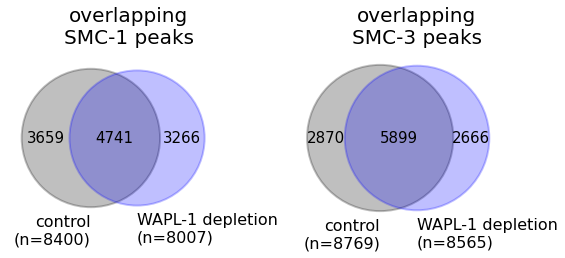

In [5]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(8, 4),
    nrows=1,
    ncols=2,
    sharey='row'
)

# (Ab,aB,AB)

subsets_smc1 = (3659,3266,4741)
subsets_smc3 = (2870,2666,5899)
dat = [subsets_smc1,subsets_smc3]

for i in range(len(dat)):
    c = venn2(ax=axs[i], subsets = dat[i],
          set_labels = ('control\n(n='+str(dat[i][2]+dat[i][0])+')',
                        'WAPL-1 depletion\n(n='+str(dat[i][2]+dat[i][1])+')'),alpha=0)
    circles = venn2_circles(ax=axs[i],subsets = dat[i])
    for circle, color in zip(circles, ['black', 'blue']):
        circle.set_lw(2.0)
#        circle.set_ls('dotted')
        circle.set_alpha(0.25)
        circle.set_color(color)
    for text in c.set_labels:
        text.set_fontsize(16)
    for text in c.subset_labels:
        text.set_fontsize(15)
f.text(0.23, 0.83, 'overlapping\nSMC-1 peaks', ha='center',fontsize=20)
f.text(0.73, 0.83, 'overlapping\nSMC-3 peaks', ha='center',fontsize=20)

plt.tight_layout()

n number 3659 3266
n number 2870 2666


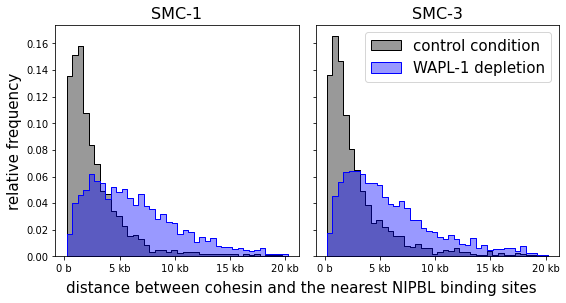

In [6]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(8, 4),
    nrows=1,
    ncols=2,
    sharey='row'
)

Maxd = 20_000
Mind = 200
dat = [smc1_unique[1],smc3_unique[1]]
loadingsite = nipbl_s.iloc[:,0:4]
loadingsite1 = loadingsite.rename(columns={0:'chrom', 1:'start', 2:'end',3:'peak_name'}, inplace=False)
subtitles = ['SMC-1', 'SMC-3']
Labels = ['control condition','WAPL-1 depletion']
for i in range(len(dat)):
    dat_i = dat[i]
    ctr_d = bioframe.closest(df1=dat_i[0],df2=loadingsite1)['distance']
    jk06_d = bioframe.closest(df1=dat_i[1],df2=loadingsite1)['distance']
    ctr_d1 = ctr_d[(ctr_d>Mind)&(ctr_d<Maxd)]
    jk06_d1 = jk06_d[(jk06_d>Mind) & (jk06_d<Maxd)]
    print('n number',len(ctr_d),len(jk06_d))
    
    a = sns.histplot(ax=axs[i],data = ctr_d1, kde = False, label=Labels[0],
                     stat = "probability",color='black',alpha=0.4,binwidth=500,element='step')
    a = sns.histplot(ax=axs[i],data = jk06_d1, kde = False, label=Labels[1],
                     stat = "probability",color='blue',alpha=0.4,binwidth=500,element='step')
    a.set_title(subtitles[i],fontsize=16)
    a.set_xlabel('')
    format_ticks(a,x=True,y=False,rotate=False)
    if i == 1:
        a.legend(prop={'size': 15})
    a.set_ylabel('relative frequency' ,rotation=90,fontsize=15,labelpad=4)
#    a.set_ylim(0,0.15)

f.text(0.53, -0.03, 'distance between cohesin and the nearest NIPBL binding sites', 
       ha='center',fontsize=15)


plt.tight_layout()